### Cab-Driver Agent

#### Defining Time Matrix

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import pylab

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Import the environment
from Env import CabDriver

# create an environment object 
env = CabDriver()

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
def Q_state(state):
    str_state = ""
    for s in state:
        if s < 10:
            str_state = str_state + "0" + str(s)
        else:
            str_state = str_state + str(s)
    return str_state

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state, q_val, action, epi):
    state1 = Q_state(state)
    Q_dict[state1][action]=q_val

In [6]:
### ?????????????

def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [7]:
### ?????????????

def initialise_tracking_states():
    sample_q_values = [('020405', (2, 4)), ('031006', (3, 5)), ('040502', (4, 3)), ('011402', (1, 3))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode         

In [8]:
# Initialise Q_dictionary and States_tracked (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

initialise_tracking_states()

In [9]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [10]:
class DQNAgent:
    
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate =  0.001      
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 32 
        self.train_start = 100
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()
        
    def save_model_graph(self):
        # serialize model to JSON
        model_json = self.model.to_json()
        with open("./cardriver_model.json", "w") as json_file:
            json_file.write(model_json)

    # approximate Q function using Neural Network
    def build_model(self):
        # Write your code here: Add layers to your neural nets       
        model = Sequential()

        # Input Layer: 5 locations + 24 hours + 7 days = 36
        # state [(1,0,0,0,0)(0 0 1 0 0 0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0)(1 0 0 0 0 0 0)]
        
        # Hidden layers: 1, 2, 3, 4 
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # Output Layer [Q(s,a1), Q(s,a2), ...... Q(s,ak)], k=21        
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model

    
    # Aravind: when to update target model? based on time interval or some other criteria
    def update_target_model(self):
        """
        TODO:
        Update the target Q-value network to current Q-value network after training for a episode. 
        This means that weights an biases of target Q-value network will become same as current Q-value network.
        """
        self.target_model.set_weights(self.model.get_weights())
    
    
    def get_action(self, state):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        
        q_value = self.model.predict(state)
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # in case of cartpole this will randomly choose an action between 0 and 1
            index = random.randrange(self.action_size)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            index = np.argmax(q_value[0])
        
        return index, q_value[0][index]

    
    def append_sample(self, state, action, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        # append the tuple (s, a, r, s', done) to memory (replay buffer) after every action
        self.memory.append((state, action, reward, next_state, done))
    
        # Decay in ε after we generate each sample from the environment
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """
        Complete the 'train_model()' function with following logic:
        
        If the memory size is greater than mini-batch size, you randomly sample experiences 
        from memory as per the mini-batch size and do the following:
        
            1. Initialise your input and output batch for training the model
            2. Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
            3. Get Q(s', a) values from the last trained model
            4. Update the input batch as your encoded state and output batch as your Q-values
            5. Then fit your DQN model using the updated input and output batch.        
        """
        if len(self.memory) < self.train_start:
            return
        
        # Sample batch from the memory
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, self.batch_size)

        # 1. Initialise your input and output batch for training the model
        update_input = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.state_size)) 
        actions, rewards, terminal_states = [], [], []

        for i in range(self.batch_size):
            # Write your code from here

            update_input[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            terminal_states.append(mini_batch[i][4])

        # 1. Predict the target from earlier model
        target = self.model.predict(update_input)

        # 2. Get the target for the Q-network
        target_qval = self.target_model.predict(update_target)  

        for i in range(self.batch_size):
            if terminal_states[i]:
                target[i][actions[i]] = rewards[i]
            else: # non-terminal state
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

        # 4. Fit your model and track the loss values
        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save_weights(name)

In [11]:
Episodes = 100

### DQN block

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 21)                693       
Total params: 5,045
Trainable params: 5,045
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 

Episode: 79   score: 1810   memory length: 2000   epsilon: 0.009998671593271896
Episode: 80   score: 2429   memory length: 2000   epsilon: 0.009998671593271896
Episode: 81   score: 2547   memory length: 2000   epsilon: 0.009998671593271896
Episode: 82   score: 2241   memory length: 2000   epsilon: 0.009998671593271896
Episode: 83   score: 2463   memory length: 2000   epsilon: 0.009998671593271896
Episode: 84   score: 2538   memory length: 2000   epsilon: 0.009998671593271896
Episode: 85   score: 2584   memory length: 2000   epsilon: 0.009998671593271896
Episode: 86   score: 2565   memory length: 2000   epsilon: 0.009998671593271896
Episode: 87   score: 2516   memory length: 2000   epsilon: 0.009998671593271896
Episode: 88   score: 2174   memory length: 2000   epsilon: 0.009998671593271896
Episode: 89   score: 2367   memory length: 2000   epsilon: 0.009998671593271896
Episode: 90   score: 2237   memory length: 2000   epsilon: 0.009998671593271896
Episode: 91   score: 2407   memory lengt

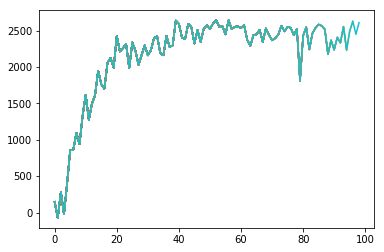

In [12]:
scores, episodes = [], []
state = env.state_init
state_encoded = env.state_encod_arch1(state)
state_size = len(state_encoded)
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    
    terminal_state = False
    score = 0
    reward = 0
    total_days = 1
    previous_day = 0
    current_day = 0
    env.reset()
    state = env.state_init
    
    #Call the DQN agent
                       
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        
        state_encoded = env.state_encod_arch1(state)
        state_encoded = np.reshape(state_encoded, [1, state_size])

        
        action, q_val = agent.get_action(state_encoded)
        
        reward = env.reward_func(state, env.action_space[action], Time_matrix)
        next_state = env.next_state_func(state, env.action_space[action], Time_matrix)
        next_state_encoded = env.state_encod_arch1(next_state)
        next_state_encoded = np.reshape(next_state_encoded, [1, state_size])
        
        agent.append_sample(state_encoded, action, reward, next_state_encoded, terminal_state)
        
        add_to_dict(state, q_val, env.action_space[action], episode)
        
        agent.train_model()
        
        score += reward
        previous_day = state[2]
        state = next_state
        current_day = state[2]
        if previous_day != current_day:
            total_days = total_days + 1
            
        if total_days > 30:
            terminal_state = True
            
        if terminal_state == True:
            agent.update_target_model()
            scores.append(score)
            episodes.append(episode)  
    
    print("Episode:", episode, "  score:", score, "  memory length:", len(agent.memory), "  epsilon:", agent.epsilon)
    
    #save the model 
    if episode % 2 == 0: 
        pylab.plot(episodes, scores)
        pylab.savefig("cardriver_dqn.png")
        agent.save("cardriver_dqn.h5")
        

In [13]:
Q_dict


defaultdict(dict,
            {'012004': {(5, 4): 1374.7557,
              (4, 5): 0.0,
              (4, 2): 1495.3345,
              (1, 3): 1755.126,
              (2, 1): 25.941385,
              (5, 3): 9.889675,
              (3, 2): 1357.7429,
              (3, 1): 1424.6832,
              (1, 5): 87.749245,
              (3, 4): 229.3011,
              (4, 3): 569.3467,
              (2, 3): 1622.6554,
              (5, 2): 0.0,
              (1, 2): 1746.9893,
              (4, 1): 1621.2277,
              (2, 4): 1488.3645},
             '040405': {(1, 4): 0.0, (4, 3): 1408.6123},
             '041405': {(5, 3): 0.0, (4, 2): 50.83521, (4, 3): 1714.5079},
             '032005': {(2, 4): 0.28491473,
              (3, 4): 1242.7456,
              (4, 3): 137.30405,
              (3, 2): 1746.2985,
              (4, 1): 242.71777,
              (3, 1): 1208.9456},
             '040706': {(5, 2): 0.0,
              (1, 2): 11.253317,
              (4, 3): 1539.2343,
              

### Tracking Convergence

In [ ]:
States_track

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

In [ ]:
plt.plot(time, epsilon)
plt.show()